# KPI 3 - Driver Lap Times - EDA and Hypothesis Testing

Load final dataset used in 3.2

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

In [211]:
df = pd.read_csv("/Users/frankdong/Documents/Analytics Local/williams-racing-strategies/processed_data/laptimes_std.csv")

In [212]:
print(df.head())
print(df.info())

   Unnamed: 0  gp_year               gp_name  gp_round      driver_name  \
0           0     2015   Austrian Grand Prix         8     Felipe Massa   
1           1     2015   Austrian Grand Prix         8  Valtteri Bottas   
2           2     2015    Belgian Grand Prix        11     Felipe Massa   
3           3     2015    Belgian Grand Prix        11  Valtteri Bottas   
4           4     2015  Brazilian Grand Prix        18     Felipe Massa   

  rookie_or_experienced laptime_std  laptime_std_ms  
0           experienced   00:09.102     9102.032818  
1           experienced   00:09.005     9005.112897  
2           experienced   00:01.252     1252.497422  
3           experienced   00:01.077     1077.893319  
4           experienced   00:03.736     3736.275146  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0  


EDA - let the data speak for itself through visualisations. 
Get to know the data both visually and statistically, lay the groundwork for analysis and hypothesis testing.
### 1. Start with core, rough visualisations. 
Histograms, boxplots, violin plots, scatterplots, barplots.  
### 2. Save all interesting "candidate" plots, output and save by exporting as PNG for review.
Plots may reveal surprising outliers, odd clusters, or clear trends
### 3. Annotate and document observations in Markdown
Write brief markdown notes next to each PNG. Note patterns, anomalies, large/small group sizes, etc.
### 4. Identify outliers, check sample sizes, assess normality. 
Key for hypothesis testing - boxplots and histograms help spot outliers and skew.
Check sample sizes with .groupby() or .value_counts() - are all groups (teams, circuits, years) large enough# for statistical tests?
### 5. Iterate and refine EDA
Select the most informative charts for polish, annotation, and inclusion in Tableau


## Steps 1, 2, 3. Rough Viz, save interesting plots, annotate observations 

"laptime consistency index" KPI now stored as laptime_std_ms. 

In [213]:
print(df["rookie_or_experienced"].value_counts())
print("\n")
# N(experienced) = 89. N(rookie) = 50. n > 30, which is good. 

rookie_or_experienced
experienced    89
rookie         50
Name: count, dtype: int64




###  1: Delta boxplot of grid delta by sector 

set up new figure and size - taller boxplot helps compare heights 

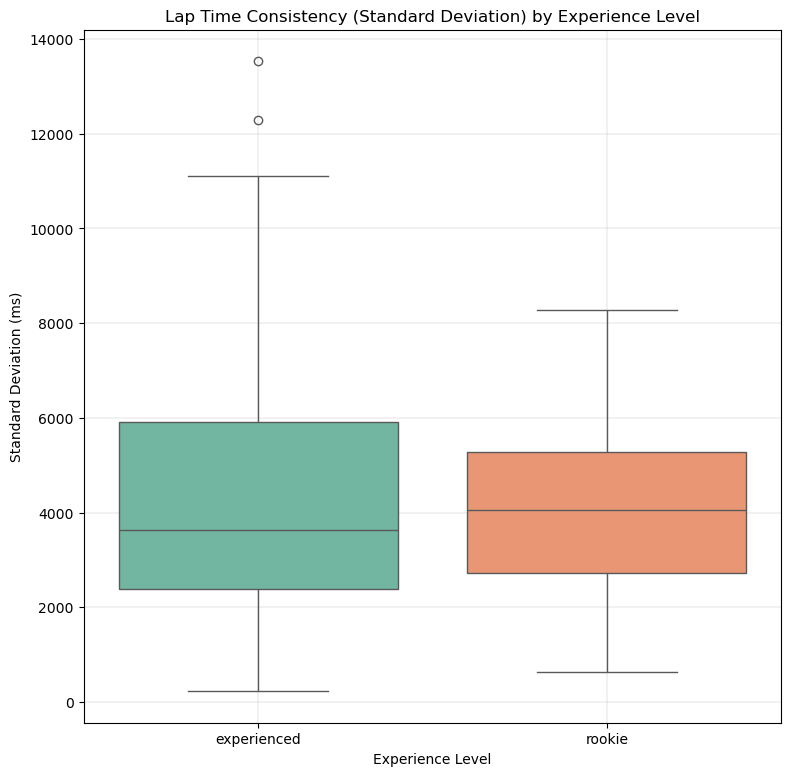

In [214]:
plt.figure(figsize=(9, 9))

consistency_by_experience = sns.boxplot(
    x = "rookie_or_experienced", 
    y = "laptime_std_ms", 
    data = df, 
    hue = "rookie_or_experienced", 
    palette = "Set2", # unbiased colour set for boxplot visualisation
    order = ["experienced", "rookie"] # order the boxes this way
)

consistency_by_experience.set_title("Lap Time Consistency (Standard Deviation) by Experience Level")
consistency_by_experience.set_xlabel("Experience Level")
consistency_by_experience.set_ylabel("Standard Deviation (ms)")

plt.grid(linewidth = 0.25)
plt.show()


This boxplot breaks down Williams" lap time consistency, the standard deviation of all lap times recorded in a race session by an experienced or rookie driver. 

The box captures the middle 50% of lap time standard deviations (the interquartile range or IQR), while the median line indicates the typical lap time consistency for each driver skill level. 

Experienced drivers demonstrate a slightly superior consistency compared to rookie drivers, with a median laptime standard deviation of 3600 ms or 3.6 s, compared to the 4050 ms or 4.05 s of rookies.

However, experienced drivers experience a more variable range of results, in both its box and whiskers.

It's box is larger compared to that of the rookies - 50% of values fall between 2.37 - 5.92s, compared to 2.71 - 5.24 s of rookies. 

The "experienced" boxplot also has a larger whisker range between 0.25 - 11.00 s and two outliers between 12 and 14 s.

These outliers need to be excluded in a final t-test.


### 2: Histplots for normality

plot a grid of histograms, with each of the three representing the sector type

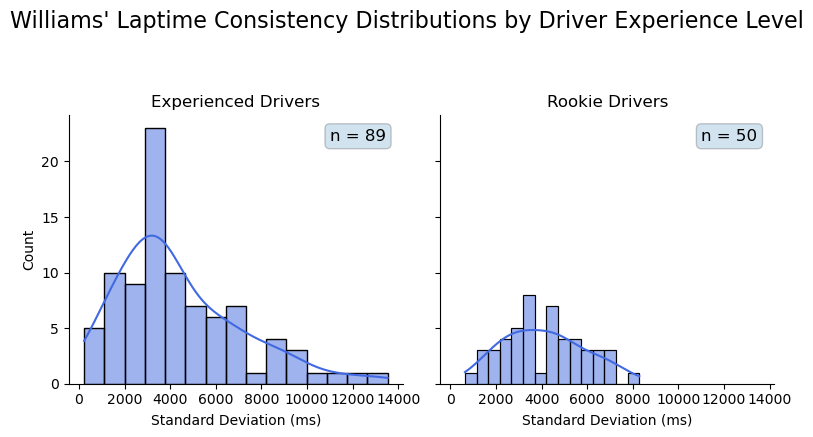

In [215]:
grid = sns.FacetGrid(
    df, 
    col = "rookie_or_experienced", 
    col_order = ["experienced", "rookie"],
    sharex = True, sharey = True, 
    height = 4, aspect = 1
)
grid.map(
    sns.histplot, 
    "laptime_std_ms", 
    kde=True, 
    stat="count", 
    bins=15, 
    color="royalblue"
)

# annotate counts to each plot on the grid
for ax, experience in zip(grid.axes.flat, ["experienced", "rookie"]):
    n = df[df["rookie_or_experienced"] == experience].shape[0]
    ax.text(0.95, 0.95, f"n = {n}", ha="right", va="top", transform=ax.transAxes,
            fontsize=12, bbox=dict(boxstyle="round", alpha=0.2))
    ax.set_xlabel("Standard Deviation (ms)")
    ax.set_ylabel("Count")
    ax.set_title(f"{experience.capitalize()} Drivers")

plt.suptitle("Williams' Laptime Consistency Distributions by Driver Experience Level", y=1.08, fontsize=16)
plt.tight_layout()
plt.show()


Rookie drivers histogram showcases a pattern which mirrors a normal distribution curve - 
making observations fairly reliable and suitable for a t-test. 

However, due to the two large outliers, the experienced drivers histogram features a long right tail, and is heavily skewed left. 

We will now label and remove these outliers before carrying out tests.


### 3: Experienced Driver Histogram, no outliers 

1. copy the dataframe into a new variable

In [216]:
df_no_outliers = df.copy()

2. identify the two largest outliers in lap time standard deviation per race/driver

In [217]:
largest_two_outliers = df_no_outliers[df_no_outliers["rookie_or_experienced"] == "experienced"].nlargest(2, "laptime_std_ms")

3. display the details of these outliers for reporting

In [218]:
print("Removed outliers (for annotation):")
print(largest_two_outliers[["gp_year", "gp_name", "driver_name", "laptime_std_ms"]])

Removed outliers (for annotation):
    gp_year               gp_name      driver_name  laptime_std_ms
24     2016  Brazilian Grand Prix     Felipe Massa    13529.598463
25     2016  Brazilian Grand Prix  Valtteri Bottas    12285.089155


4. drop the two largest outliers from your experienced drivers DataFrame

In [219]:
df_no_outliers = df_no_outliers.drop(largest_two_outliers.index)

5. replot the histogram with KDE for the cleaned data

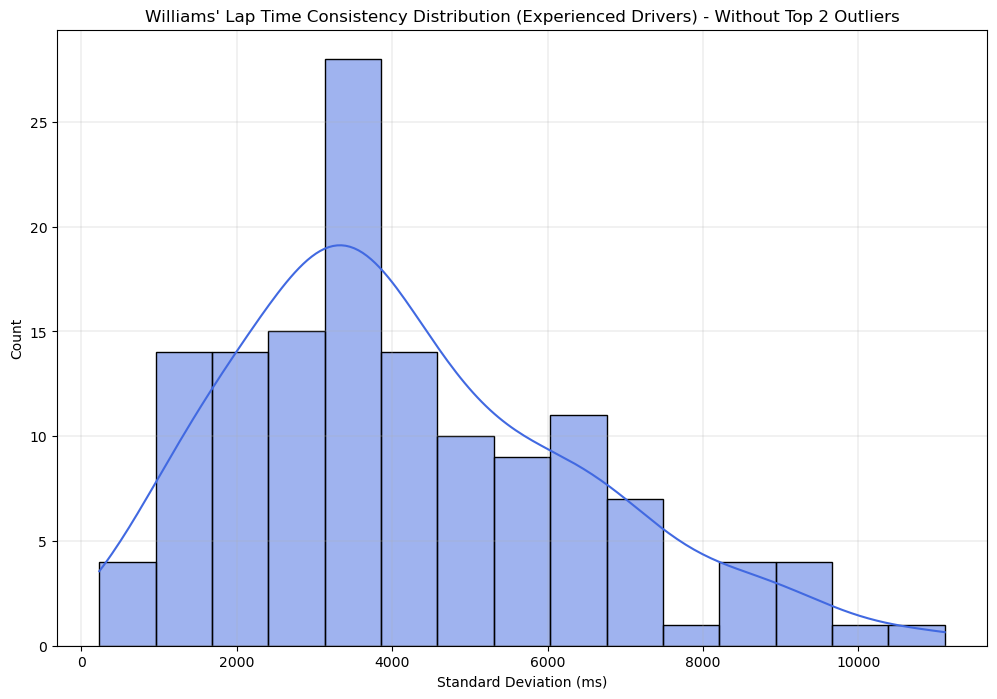



     Unnamed: 0  gp_year               gp_name  gp_round      driver_name  \
0             0     2015   Austrian Grand Prix         8     Felipe Massa   
1             1     2015   Austrian Grand Prix         8  Valtteri Bottas   
2             2     2015    Belgian Grand Prix        11     Felipe Massa   
3             3     2015    Belgian Grand Prix        11  Valtteri Bottas   
4             4     2015  Brazilian Grand Prix        18     Felipe Massa   
..          ...      ...                   ...       ...              ...   
134         134     2019  Singapore Grand Prix        15  Valtteri Bottas   
135         135     2019    Spanish Grand Prix         5   George Russell   
136         136     2019    Spanish Grand Prix         5     Lance Stroll   
137         137     2019    Spanish Grand Prix         5    Robert Kubica   
138         138     2019    Spanish Grand Prix         5  Valtteri Bottas   

    rookie_or_experienced laptime_std  laptime_std_ms  
0             exp

In [220]:
plt.figure(figsize=(12, 8)) # set up a new figure

no_outliers_histplot = sns.histplot(
    df_no_outliers["laptime_std_ms"], 
    kde=True, 
    bins=15, 
    color="royalblue"
)

no_outliers_histplot.set_title("Williams' Lap Time Consistency Distribution (Experienced Drivers) - Without Top 2 Outliers")
no_outliers_histplot.set_xlabel("Standard Deviation (ms)")
no_outliers_histplot.set_ylabel("Count")

plt.grid(linewidth=0.25)
plt.show()

print("\n")
print(df_no_outliers) # a dataframe, storing no outliers, is now available here.

Compared to the previous histplot, this one is slightly less left skewed, with the exclusion of the two largest outliers specified by the boxplot. 


However, ~10 values between 8,000 and 11,000 ms result in a stronger right tail. 

Remember, most parametric tests, e.g. t-test for mean, assume the data has no major outliers, and is roughly normal. 

A big negative outlier can inflate the calculated standard error, making it harder to achieve statistical significance.

However, as we meet n > 30 for both samples, and roughly normal distributions - let"s carry out both a parametric and a non-parametric test -> Welch's t-test and Mann Whitney U Test

------------------ Step 4. Perform hypothesis testing ------------------

Count the samples involved: 

In [221]:
sample_counts = df_no_outliers["rookie_or_experienced"].value_counts()
print("\nSample sizes: ", sample_counts)


Sample sizes:  rookie_or_experienced
experienced    87
rookie         50
Name: count, dtype: int64


For both samples, n > 30. 

Rookie is roughly normal is shape, but experienced is slighly skewed left. 

Perform a standard Welch's t-test followed by a Mann-Whitney U Test 

Make observations, note differences, compare results at a 95% confidence level.




Hypothesis Recap: 
Rookie drivers had higher lap time variance then their teammates during the 2015-2019 seasons.
Groups: 
- Experienced: n = 87
- Rookie: n = 50
- Two different populations - experienced drivers and rookies.
- Testing if rookies have greater standard deviation, not just different. Direction matters.
Two-sample, independent, one-tailed Welch's t-test. 
H0 (Null): μ_Rookie ≤ μ_Experienced
H1 (Alt): μ_Rookie > μ_Experienced


1. extract relevant data for the test

In [222]:
experienced_data = df_no_outliers[df_no_outliers["rookie_or_experienced"] == "experienced"]["laptime_std_ms"]
rookie_data = df_no_outliers[df_no_outliers["rookie_or_experienced"] == "rookie"]["laptime_std_ms"]

2. run the Welch's one-tailed t-test

In [223]:
t_stat, p_value = ttest_ind(
    rookie_data, 
    experienced_data, 
    equal_var = False,
    alternative = "greater" # defines alternative hypothesis
)

In [224]:
print("\nWelch's t-test for rookies vs. experienced drivers consistency 95% confidence level.\n")
print(f"t-statistic: {t_stat:.3f}")
print(f"One-tailed p-value: {p_value:.4f}")


Welch's t-test for rookies vs. experienced drivers consistency 95% confidence level.

t-statistic: -0.214
One-tailed p-value: 0.5844


In [225]:
alpha = 0.05  # 95% confidence level
if p_value < alpha:
    print("\nReject the null hypothesis (H1): Rookies have significantly higher lap time variance than experienced drivers during 2015-2019")
else: # p_value_one_tailed >= alpha
    print("\nFail to reject the null (H0): No significant evidence that rookies have greater lap time variance compared to experienced drivers between 2015-2019.")


Fail to reject the null (H0): No significant evidence that rookies have greater lap time variance compared to experienced drivers between 2015-2019.




Welch"s t-test for rookies vs. experienced drivers consistency 95% confidence interval.
t-statistic: -0.214
One-tailed p-value: 0.5844
Fail to reject the null (H0): No significant evidence that rookies have graeter lap time variance compared to experienced drivers between 2015-2019.
A H0 result here, but let"s check the non-parametric test first before we jump to conclusions.


3. Run the Mann-Whitney U Test

In [226]:
m_stat, p_value_2 = mannwhitneyu(rookie_data, experienced_data, alternative="greater")

In [227]:
print("\nMann-Whitney U Test for rookies vs. experienced drivers consistency at 95% confidence level.")
print(f"Mann-Whitney U statistic: {m_stat:.3f}")
print(f"One-tailed p-value: {p_value_2:.4f}")


Mann-Whitney U Test for rookies vs. experienced drivers consistency at 95% confidence level.
Mann-Whitney U statistic: 2256.000
One-tailed p-value: 0.3595


In [228]:
if p_value_2 < alpha:
    print("\nReject the null hypothesis (H1): Rookies have significantly higher lap time variance than experienced drivers during 2015-2019")
else: # p_value_one_tailed >= alpha
    print("\nFail to reject the null (H0): No significant evidence that rookies have greater lap time variance compared to experienced drivers between 2015-2019.")


Fail to reject the null (H0): No significant evidence that rookies have greater lap time variance compared to experienced drivers between 2015-2019.




Mann-Whitney U Test for rookies vs. experienced drivers consistency at 95% confidence level.
Mann-Whitney U statistic: 2256.000
One-tailed p-value: 0.3595
Fail to reject the null (H0): No significant evidence that rookies have greater lap time variance compared to experienced drivers between 2015-2019.




Both p-values are well above the 95% confidence level, 0.05 threshold
This means there"s insufficient evidence to reject the null hypothesis that rookies do not have greater lap time variance.
The data does not support the claim that rookies have significantly less consistency than their experienced teammates
over those seasons. 
Interventions aimed solely at rookies for consistency improvement might require re-evaluation, or further factors 
should be carefully investigated. 


## Step 5. Explore other visualisations

### 1. driver consistency trajectory over a season

plot lap time variance per GP over the course of a season for each driver, to: 
- see if rookies improve race-to-race - a proxy for learning/adaptation
- see if experienced drivers stay consistent, or degrade due to age, car, team issues. 
- enable individual case studies, such as: 
    - 2015: massa and bottas - 2nd season together
    - 2016: massa and bottas - 3rd and final season for two experienced drivers
    - 2017: lance stroll - rookie season. felipe massa - final season.
    - 2018: sirotkin - rookie F1 season.
    - 2019: george russell - rookie season. kubica - return to F1 (experienced)


example - george russell, 2019 rookie season

In [229]:
driver_name = "George Russell"
season = 2019

filter data

In [230]:
df_driver_season = df[
    (df["driver_name"] == driver_name) & 
    (df["gp_year"] == season)
]

sort by gp_round for proper chronological order

In [231]:
df_driver_season = df_driver_season.sort_values(by="gp_round")

create combined column for better x-axis labels (optional)

In [232]:
df_driver_season["gp_round_and_name"] = df_driver_season["gp_round"].astype(str) + ": " + df_driver_season["gp_name"]

plot

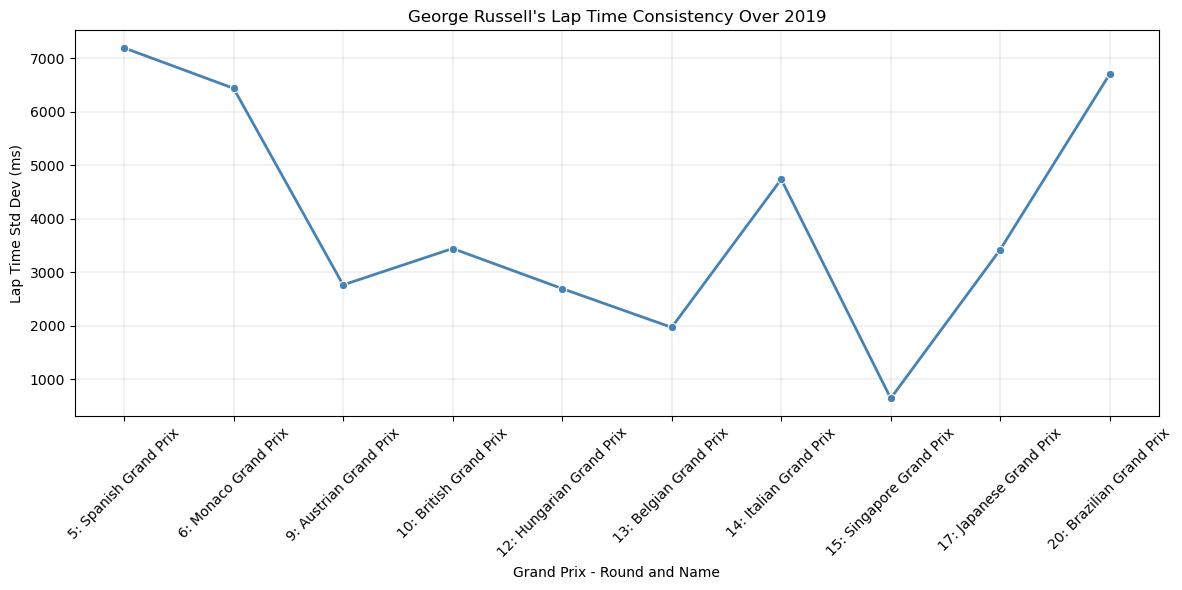

In [233]:
plt.figure(figsize=(12, 6))

russell_2019_consistency = sns.lineplot(
    data=df_driver_season,
    x="gp_round_and_name",  # using the combined column
    y="laptime_std_ms",
    marker="o",
    linewidth=2,
    color="steelblue"
)

russell_2019_consistency.set_title(f"{driver_name}'s Lap Time Consistency Over {season}")
russell_2019_consistency.set_xlabel("Grand Prix - Round and Name")
russell_2019_consistency.set_ylabel("Lap Time Std Dev (ms)")
russell_2019_consistency.tick_params(axis="x", rotation = 45)

plt.grid(linewidth=0.25)
plt.tight_layout()
plt.show()

Based on this snapshot of 10 GPs from Russell"s 2019 rookie season (approximately half the season), the data shows promising signs of adaptation and improved consistency. 

Russell demonstrates a general trend toward better lap-to-lap consistency throughout the year, with his laptime standard deviation improving from ~7.2s early in the season to around 2s  in several mid-season races.

Notably, his most consistent performances (~0.6s std dev) occur at Monaco, Hungary, and Singapore.

While these are technical circuits that traditionally reward precision, it's important to note that they are also typically processional races with fewer overtaking opportunities and more stable race conditions - factors that naturally contribute to lower lap time variability regardless of driver skill development.

The higher variability seen in Japan (~3.4s) and Brazil (~6.75s) should be interpreted cautiously.

With significant data gaps - particularly the four-race span between Singapore (Round 15) and Brazil (Round 20) covering Russia, Japan, Mexico, and USA - we cannot definitively assess whether this represents a decline in consistency or is influenced by external factors such as incidents, weather conditions, or strategic decisions that fall outside our current analysis scope.

Overall, this partial season snapshot suggests Russell showed encouraging signs of adaptation as a rookie, though a complete dataset would be needed to draw more definitive conclusions about his consistency trajectory.


... repeating this for other drivers, 

### 2. 2018 - visualising the performance of two rookies driving with each other - stroll and sirotkin

In [234]:
# combine both lines on a single plot

driver_names = ["Lance Stroll", "Sergey Sirotkin"]
season = 2018

df_driver_season = df[
    (df["driver_name"].isin(driver_names)) & 
    (df["gp_year"] == season)
]

sort races by gp_round

In [235]:
df_driver_season = df_driver_season.sort_values(by="gp_round")

df_driver_season["gp_round_and_name"] = df_driver_season["gp_round"].astype(str) + ": " + df_driver_season["gp_name"]

plot

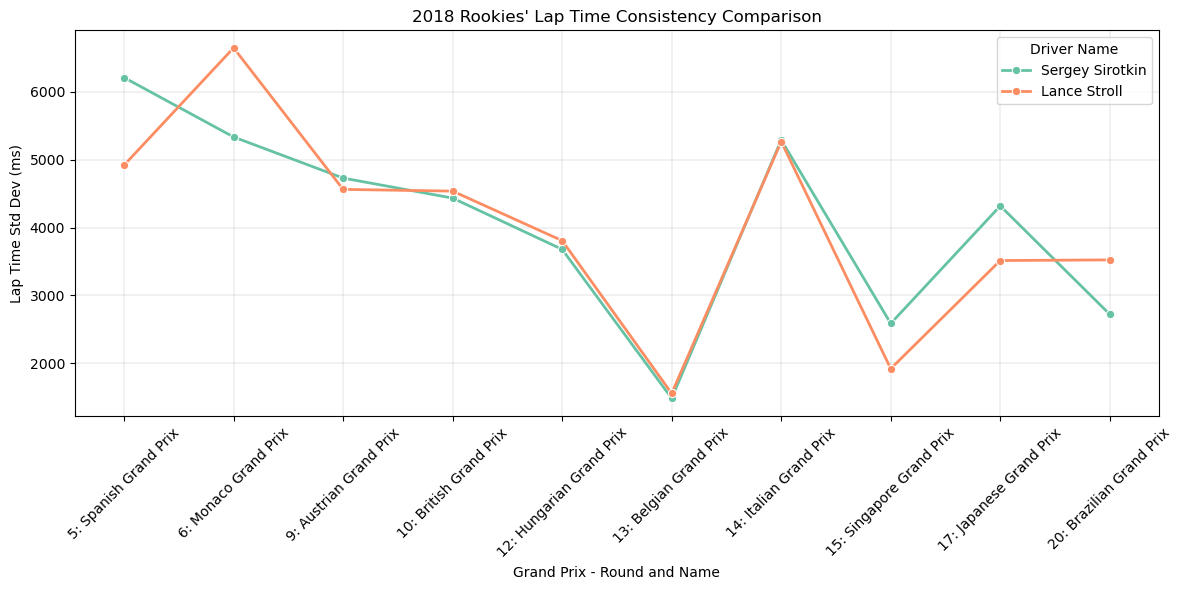

In [236]:
plt.figure(figsize=(12, 6))

rookies_2018_consistency = sns.lineplot(
    data=df_driver_season,
    x="gp_round_and_name",  
    y="laptime_std_ms",
    hue = "driver_name",
    palette = "Set2",
    marker="o",
    linewidth=2,
)

rookies_2018_consistency.set_title(f"2018 Rookies' Lap Time Consistency Comparison")
rookies_2018_consistency.set_xlabel("Grand Prix - Round and Name")
rookies_2018_consistency.set_ylabel("Lap Time Std Dev (ms)")
rookies_2018_consistency.tick_params(axis="x", rotation = 45)

plt.legend(title="Driver Name") # add legend
plt.grid(linewidth=0.25) # add gridlines
plt.tight_layout()
plt.show()

3. 2015 - 2nd year for two veteran driver combo

In [237]:
driver_names = ["Valtteri Bottas", "Felipe Massa"]
season = 2015

df_driver_season = df[
    (df["driver_name"].isin(driver_names)) & 
    (df["gp_year"] == season)
]

sort races by gp_round

In [238]:
df_driver_season = df_driver_season.sort_values(by="gp_round")

df_driver_season["gp_round_and_name"] = df_driver_season["gp_round"].astype(str) + ": " + df_driver_season["gp_name"]

plot

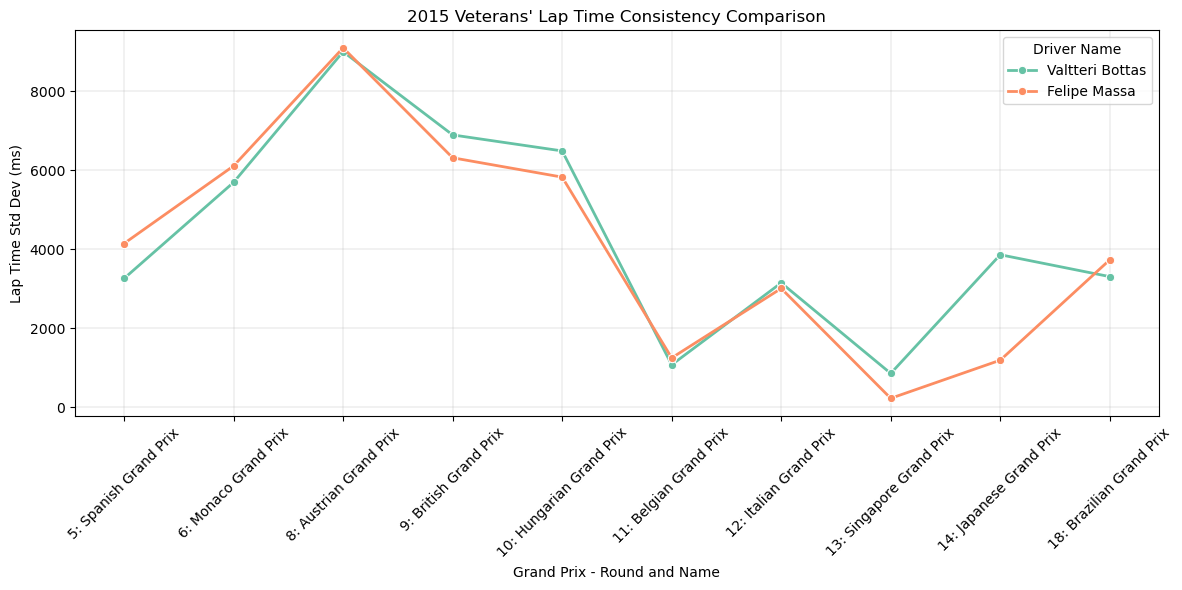

In [239]:
plt.figure(figsize=(12, 6))

veterans_2015_consistency = sns.lineplot(
    data=df_driver_season,
    x="gp_round_and_name",  
    y="laptime_std_ms",
    hue = "driver_name",
    palette = "Set2",
    marker="o",
    linewidth=2,
)

veterans_2015_consistency.set_title(f"2015 Veterans' Lap Time Consistency Comparison")
veterans_2015_consistency.set_xlabel("Grand Prix - Round and Name")
veterans_2015_consistency.set_ylabel("Lap Time Std Dev (ms)")
veterans_2015_consistency.tick_params(axis="x", rotation = 45)

plt.legend(title="Driver Name") # add legend
plt.grid(linewidth=0.25) # add gridlines
plt.tight_layout()
plt.show()

3. 2016 - 3rd and final year for two veteran driver combo

In [240]:
driver_names = ["Valtteri Bottas", "Felipe Massa"]
season = 2016

df_driver_season = df[
    (df["driver_name"].isin(driver_names)) & 
    (df["gp_year"] == season)
]

# sort races by gp_round

df_driver_season = df_driver_season.sort_values(by="gp_round")
df_driver_season["gp_round_and_name"] = df_driver_season["gp_round"].astype(str) + ": " + df_driver_season["gp_name"]

plot

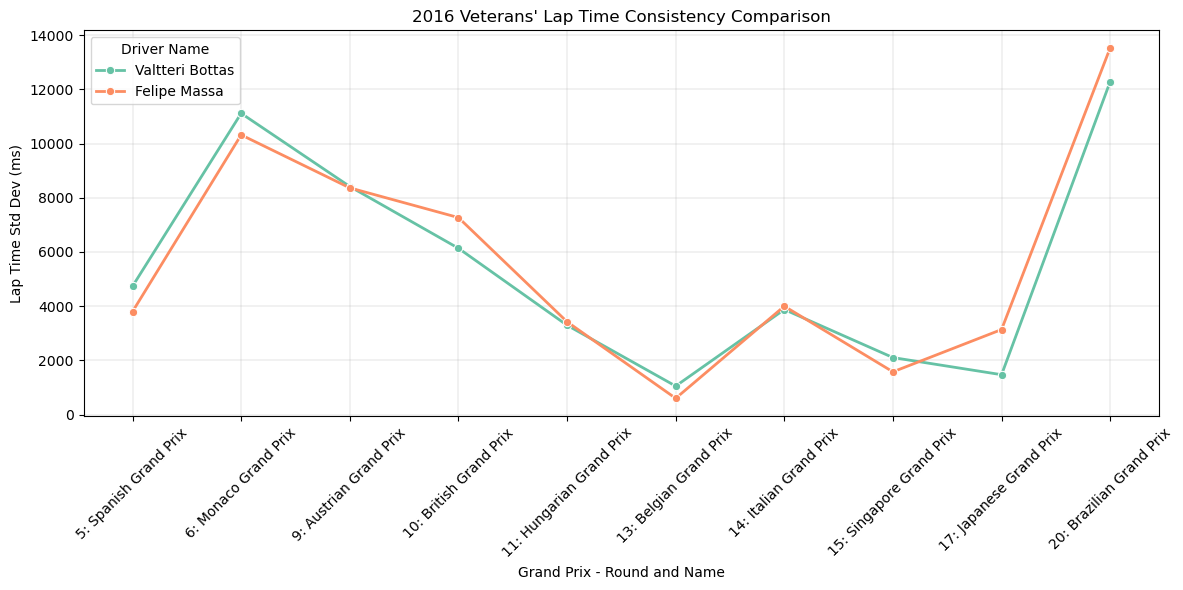

In [241]:
plt.figure(figsize=(12, 6))

veterans_2016_consistency = sns.lineplot(
    data=df_driver_season,
    x="gp_round_and_name",  
    y="laptime_std_ms",
    hue = "driver_name",
    palette = "Set2",
    marker="o",
    linewidth=2,
)

veterans_2016_consistency.set_title(f"2016 Veterans' Lap Time Consistency Comparison")
veterans_2016_consistency.set_xlabel("Grand Prix - Round and Name")
veterans_2016_consistency.set_ylabel("Lap Time Std Dev (ms)")
veterans_2016_consistency.tick_params(axis="x", rotation = 45)

plt.legend(title="Driver Name") # add legend
plt.grid(linewidth=0.25) # add gridlines
plt.tight_layout()
plt.show()

4. Combined 2015 vs 2016 - Same veterans, same tracks, different years

In [242]:
driver_names = ["Valtteri Bottas", "Felipe Massa"]
seasons = [2015, 2016]

gp_order = ['Spanish', 'Monaco', 'Austrian', 'British', 'Hungarian', 
           'Belgian', 'Italian', 'Singapore', 'Japanese', 'Brazilian']

# filter data for both seasons
df_combined = df[
    (df["driver_name"].isin(driver_names)) & 
    (df["gp_year"].isin(seasons))
]

# extract GP type from gp_name (e.g., "Spanish Grand Prix" -> "Spanish")
df_combined['gp_type'] = df_combined['gp_name'].str.replace(' Grand Prix', '')

# filter only the common GPs and create ordering
df_combined = df_combined[df_combined['gp_type'].isin(gp_order)]

# create a categorical column for proper ordering

df_combined['gp_type'] = pd.Categorical(df_combined['gp_type'], categories=gp_order, ordered=True) 

# sort by GP order
df_combined = df_combined.sort_values(by='gp_type')

# create separate columns for styling
df_combined['driver_year'] = df_combined['driver_name'] + ' (' + df_combined['gp_year'].astype(str) + ')'
df_combined['year_str'] = df_combined['gp_year'].astype(str)

/var/folders/bj/v339qbwd7zj2hlpp87q7ks_w0000gn/T/ipykernel_23571/1843342100.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['gp_type'] = df_combined['gp_name'].str.replace(' Grand Prix', '')


Plot

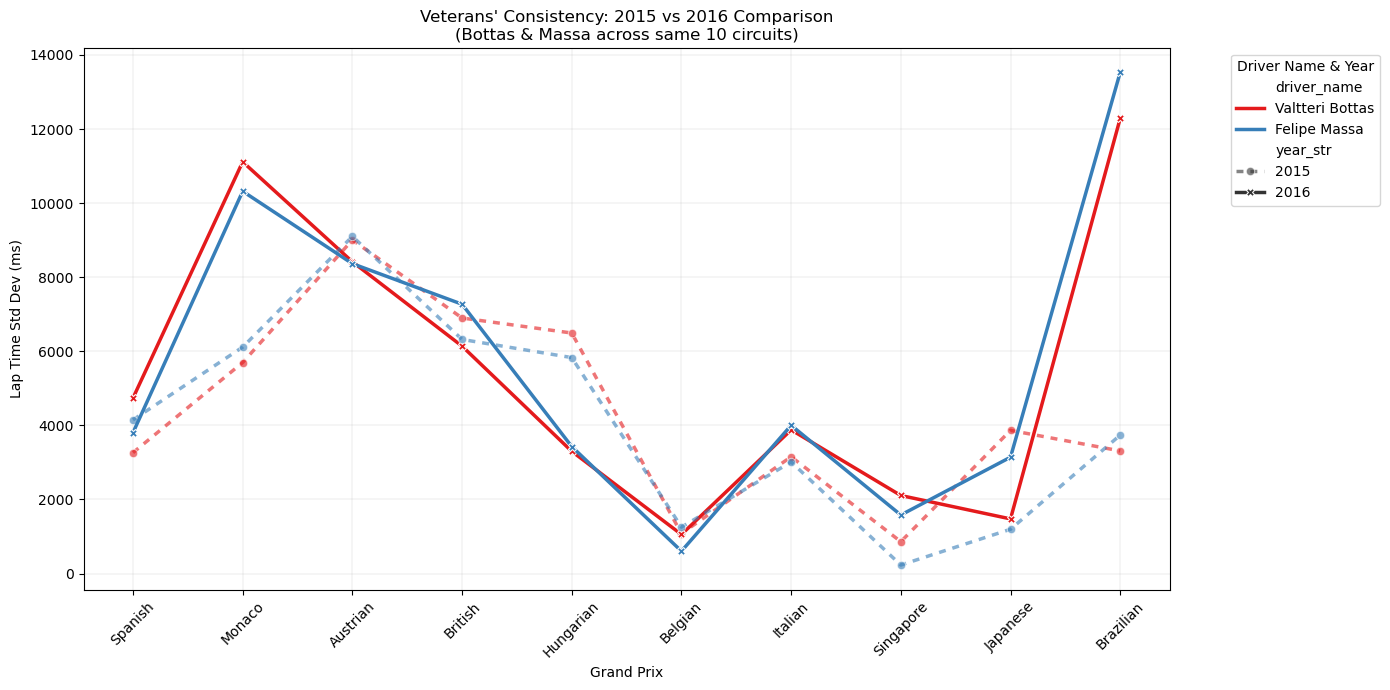

In [243]:
plt.figure(figsize=(14, 7))

veterans_comparison = sns.lineplot(
    data=df_combined,
    x="gp_type",
    y="laptime_std_ms",
    hue="driver_name",  # Color by driver
    style="year_str",   # Line style by year
    palette="Set1",
    markers=True,
    linewidth=2.5,
    markersize=6,
    dashes={"2015": (2, 2), "2016": ""},  # Dotted for 2015, solid for 2016
    alpha=0.9  # We'll adjust this manually below
)

# adjust the alpha for each line 

for line in veterans_comparison.get_lines():
    # Check if it's a 2015 line (dotted lines will have dashes)
    if line.get_linestyle() == '--':
        line.set_alpha(0.6)  # Reduced alpha for 2015
    else:
        line.set_alpha(1.0)  # Strong alpha for 2016

veterans_comparison.set_title("Veterans' Consistency: 2015 vs 2016 Comparison\n(Bottas & Massa across same 10 circuits)")
veterans_comparison.set_xlabel("Grand Prix")
veterans_comparison.set_ylabel("Lap Time Std Dev (ms)")
veterans_comparison.tick_params(axis="x", rotation=45)

# customise legend
handles, labels = veterans_comparison.get_legend_handles_labels()
plt.legend(handles, labels, title="Driver Name & Year", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(linewidth=0.25, alpha=0.7)
plt.tight_layout()
plt.show() 

5. 2019 - a rookie and a veteran - russell vs kubica

In [244]:
driver_names = ["George Russell", "Robert Kubica"]
season = 2019

df_driver_season = df[
    (df["driver_name"].isin(driver_names)) & 
    (df["gp_year"] == season)
]

# sort races by gp_round
df_driver_season = df_driver_season.sort_values(by="gp_round")

df_driver_season["gp_round_and_name"] = df_driver_season["gp_round"].astype(str) + ": " + df_driver_season["gp_name"]

plot

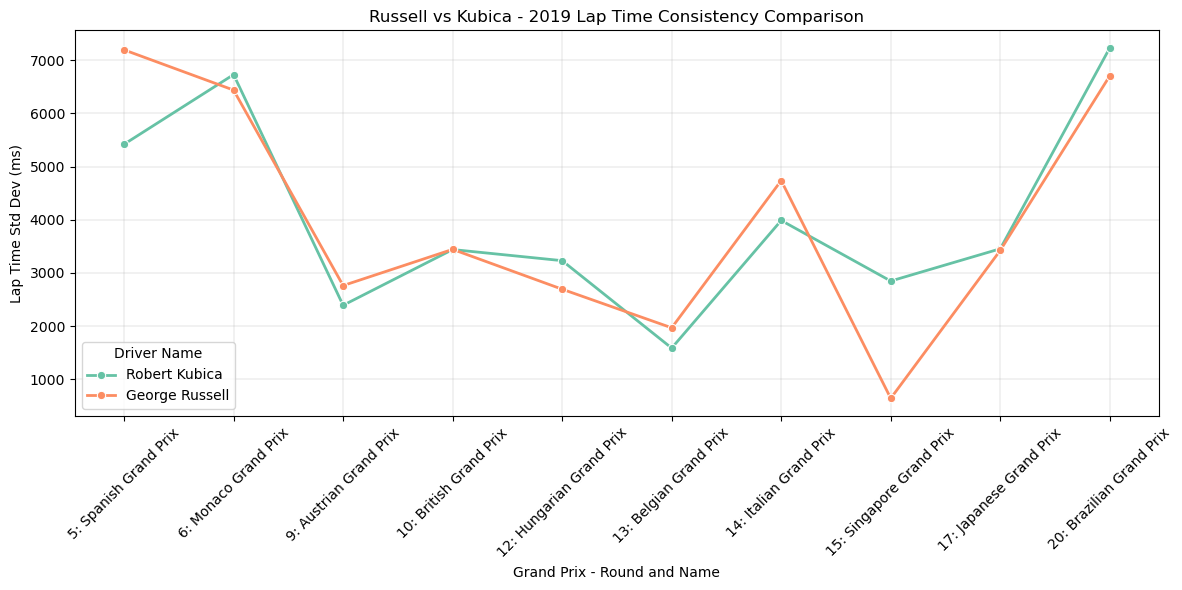

In [245]:
plt.figure(figsize=(12, 6))

vs_2019_consistency = sns.lineplot(
    data=df_driver_season,
    x="gp_round_and_name",  
    y="laptime_std_ms",
    hue = "driver_name",
    palette = "Set2",
    marker="o",
    linewidth=2,
)

vs_2019_consistency.set_title(f"Russell vs Kubica - 2019 Lap Time Consistency Comparison")
vs_2019_consistency.set_xlabel("Grand Prix - Round and Name")
vs_2019_consistency.set_ylabel("Lap Time Std Dev (ms)")
vs_2019_consistency.tick_params(axis="x", rotation = 45)

plt.legend(title="Driver Name") # add legend
plt.grid(linewidth=0.25) # add gridlines
plt.tight_layout()
plt.show()

------------------------------------------------------------------------------------------

### 6. Driver performance stripplots

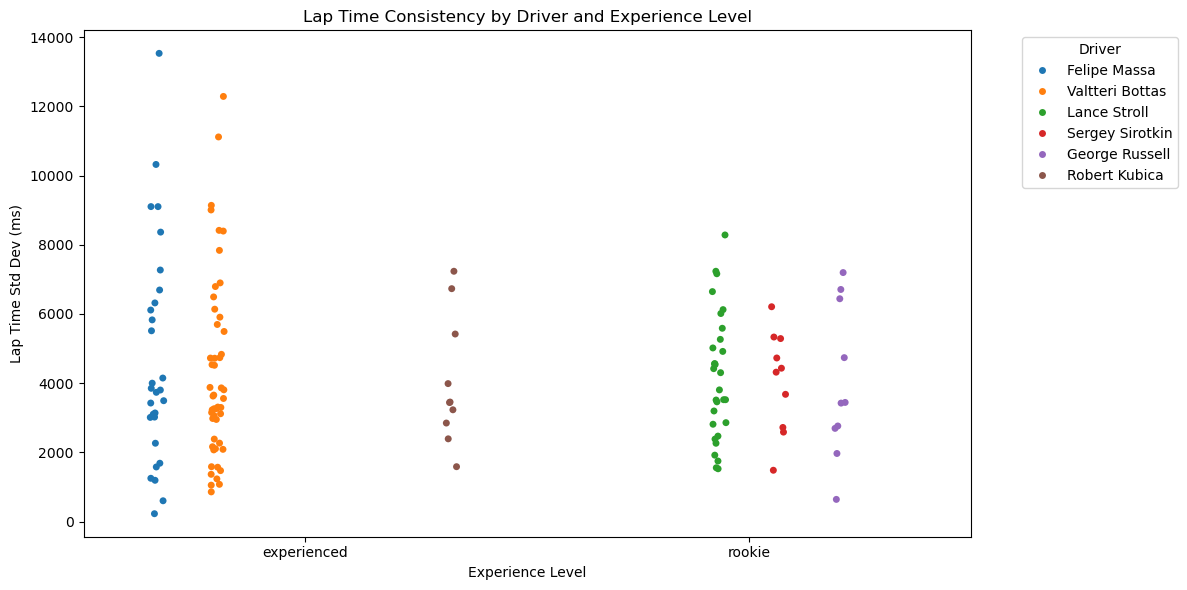

In [246]:
plt.figure(figsize=(12,6))

consistency_stripplot = sns.stripplot(
    data=df, 
    x='rookie_or_experienced', 
    y='laptime_std_ms', 
    hue='driver_name', 
    jitter=True, 
    dodge=True,
    palette='tab10'
)

consistency_stripplot.set_title("Lap Time Consistency by Driver and Experience Level")
consistency_stripplot.set_xlabel("Experience Level")
consistency_stripplot.set_ylabel("Lap Time Std Dev (ms)")

plt.legend(title='Driver', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



The large gap between Kubica and the other experienced drivers serve to identify the time period
of his return, and indicates different consistency patterns compared to the Massa/Bottas era. 
Another notable observation - as we limited our circuit selection, we a limited number of entries for Kubica, Sirotkin, and Russell. 
Drivers like Stroll, Massa, and Bottas have driven for more than 1 season, hence the larger number of data entries. 


### 7. race-by-race boxplot of std dev -> gp_name as an x-axis

Let's understand: do certain races create more lap time variability?

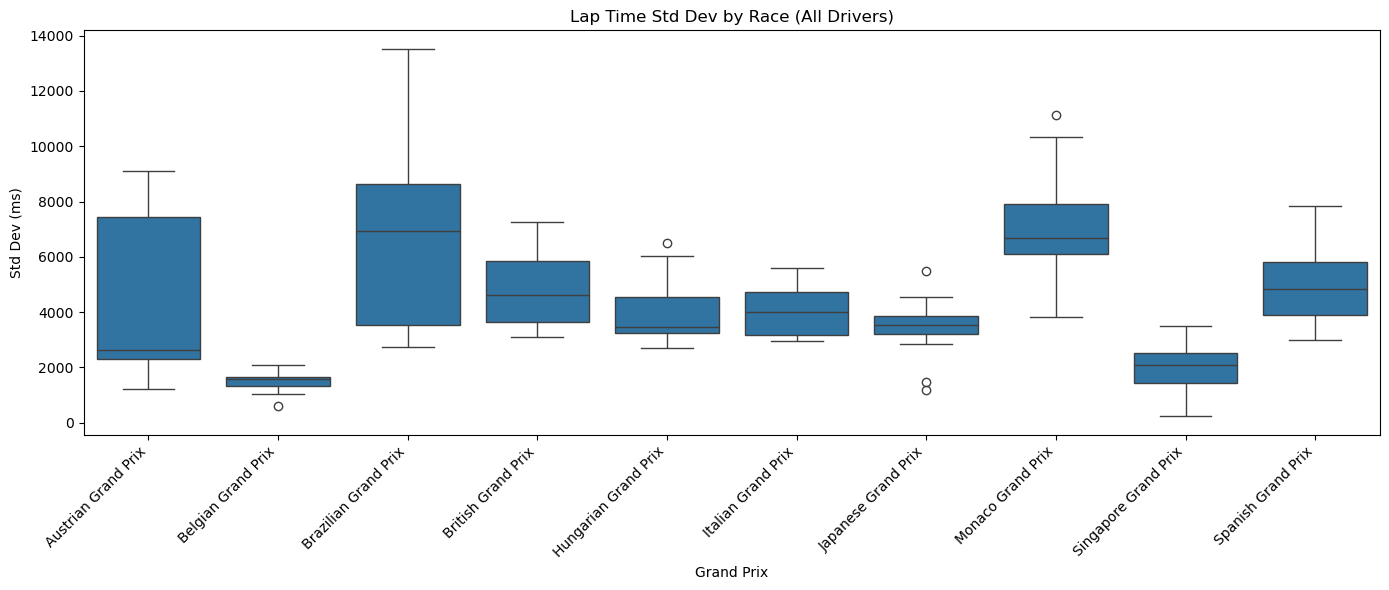

In [247]:
plt.figure(figsize=(14,6))

gp_boxplot = sns.boxplot(data=df, x='gp_name', y='laptime_std_ms')

gp_boxplot.set_title("Lap Time Std Dev by Race (All Drivers)")
gp_boxplot.set_ylabel("Std Dev (ms)")
gp_boxplot.set_xlabel("Grand Prix")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 8. Violin plot with distribution detail

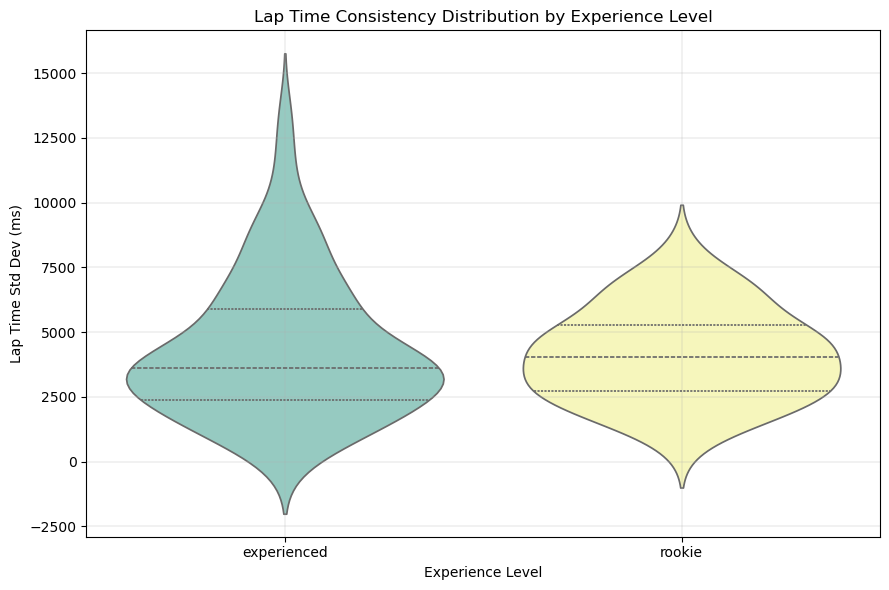

In [248]:
plt.figure(figsize=(9, 6))

violin = sns.violinplot(
    data=df, 
    x='rookie_or_experienced', 
    y='laptime_std_ms', 
    hue = 'rookie_or_experienced',
    palette='Set3', 
    inner='quartile'
)

violin.set_title("Lap Time Consistency Distribution by Experience Level")
violin.set_xlabel("Experience Level")
violin.set_ylabel("Lap Time Std Dev (ms)")

plt.tight_layout()
plt.grid(linewidth = 0.25)
plt.show()

### 9. Pairplot - to explore correlations

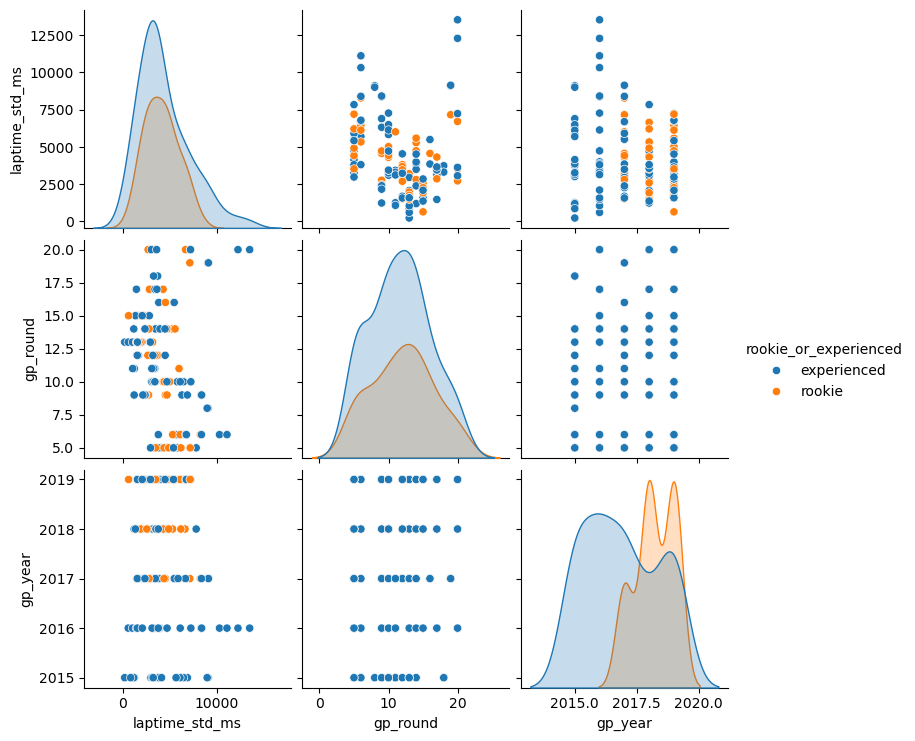

In [249]:
sns.pairplot(
    data = df, 
    hue='rookie_or_experienced', 
    vars=['laptime_std_ms', 'gp_round', 'gp_year']
)  
plt.show()